
1. Download and load the data. Perform the initial exploration and cleaning.
   - it is already split into training and testing parts
   - labels go from 0 to 76
   - checks should include e.g.:
     - checking data types, number of texts,
     - plotting the class distribution
     - plotting the histogram of text lengths

In [1]:
import os

# gets rid of irritating warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import pandas as pd
from datasets import load_dataset

df = load_dataset("PolyAI/banking77", trust_remote_code=True)["train"].to_pandas()

In [3]:
df.dtypes, len(df)

(text     object
 label     int64
 dtype: object,
 10003)

<Axes: title={'center': 'class distribution'}, xlabel='label', ylabel='n'>

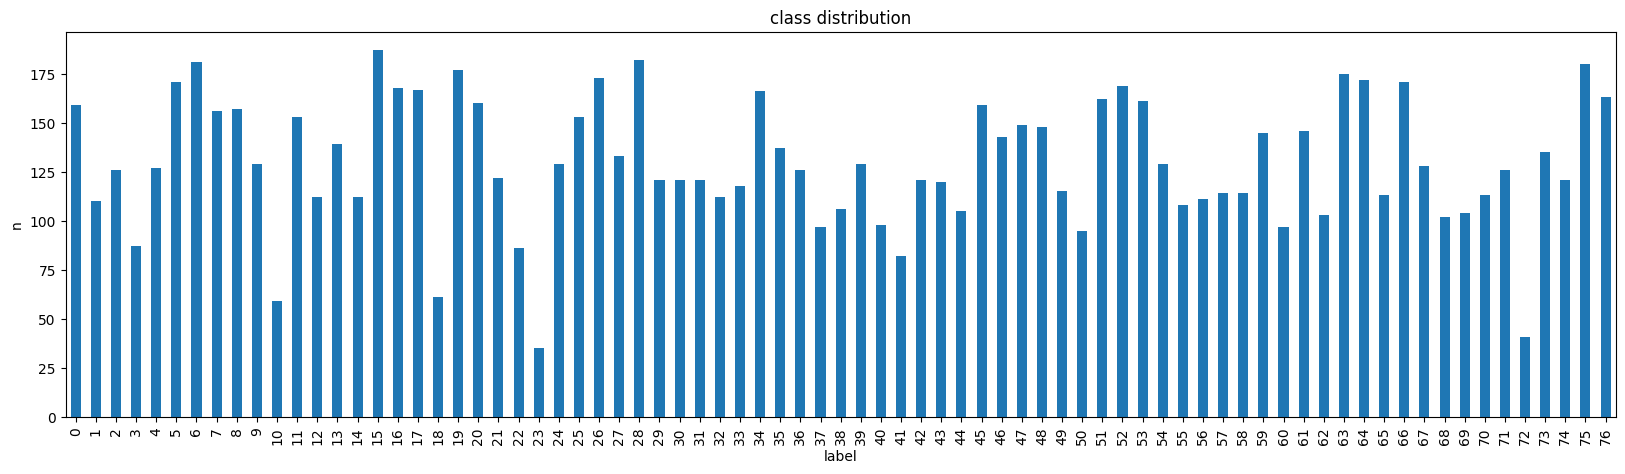

In [4]:
df["label"].value_counts().sort_index().plot.bar(
        figsize=(20, 5),
        ylabel="n",
        xlabel="label",
        title="class distribution",
    )

<Axes: title={'center': 'histogram of text lengths'}, xlabel='length', ylabel='n'>

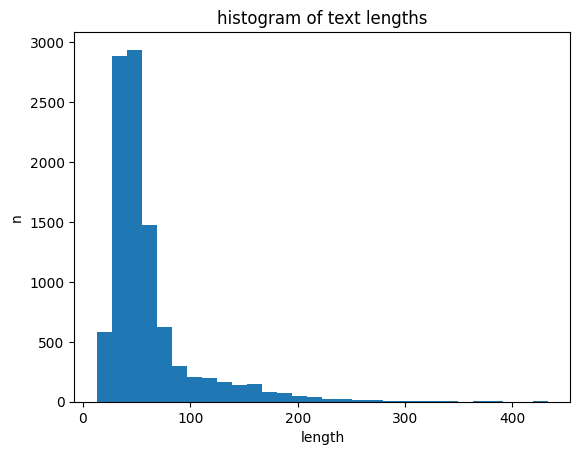

In [5]:
df["text"].str.len().plot.hist(
        bins=30,
        title="histogram of text lengths",
        ylabel="n",
        xlabel="length"
    )

2. Use CleanLab to detect and fix data quality issues:
   - use `all-MiniLM-L6-v2` Sentence Transformer embeddings + logistic regression as the model
   - note that `LogisticRegressionCV` works out-of-the-box for multiclass classification, and
     you should use `class_weight="balanced"` in case of class imbalance
   - detect and fix: label issues, near duplicates, outliers
   - when analyzing duplicates, you can print rows at given indices with `.iloc[]`
   - comment:
     - do your results agree with [the paper](https://aclanthology.org/2022.insights-1.19/)
       pointing out the label quality issues?
     - are the problems severe and worth fixing in your opinion?

In [6]:
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict


def get_initial_model_data(texts: np.ndarray, labels: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    transformer = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = transformer.encode(texts, show_progress_bar=False, convert_to_numpy=True)

    clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=0)
    pred_probs = cross_val_predict(clf, embeddings, labels, cv=5, method="predict_proba")

    return embeddings, pred_probs

In [7]:
texts = df["text"].values
labels = df["label"].values

embeddings, pred_probs = get_initial_model_data(texts, labels)

In [8]:
from cleanlab import Datalab


data_dict = {"texts": texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels", task="classification")
lab.find_issues(pred_probs=pred_probs, features=embeddings)
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 648 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
         label         166
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
  

In [9]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]
label_issues = label_issues.sort_values(by="label_score")

In [10]:
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")

In [11]:
outlier_issues = lab.get_issues("outlier")
outlier_issues = outlier_issues[outlier_issues["is_outlier_issue"]]
outlier_issues = outlier_issues.sort_values(by="outlier_score")

In [12]:
print("LABEL ISSUES")
print(f"{len(label_issues)}/{len(df)}")
print(df["text"][label_issues.head(3).index])

print("\n\nDUPLICATES")
print(f"{len(duplicate_issues)}/{len(df)}")

near_duplicates_sets_ids = [el[0] for el in duplicate_issues.head(5)["near_duplicate_sets"]]
print("Target")
print(df["text"][duplicate_issues.head(5).index])
print("\nNear duplicate")
print(df["text"][near_duplicates_sets_ids])


print("\n\nOUTLIERS")
print(f"{len(outlier_issues)}/{len(df)}")
print(df["text"][outlier_issues.head(3).index])

LABEL ISSUES
166/10003
1931    i put money on my card and i dont see it on th...
4428    i am not a premium customer but i want a virtu...
4974    Is my card actually working? It's the first ti...
Name: text, dtype: object


DUPLICATES
350/10003
Target
1710    \nI put the wrong pin too many times and now i...
1290       \nI can't seem to be able to use my card\n\n\n
1246               I can't seem to be able to use my card
4594                     Where can I withdraw money from?
4595                   \nWhere can I withdraw money from?
Name: text, dtype: object

Near duplicate
1724    I put the wrong pin too many times and now it ...
1246               I can't seem to be able to use my card
1290       \nI can't seem to be able to use my card\n\n\n
4595                   \nWhere can I withdraw money from?
4594                     Where can I withdraw money from?
Name: text, dtype: object


OUTLIERS
131/10003
3107    WHAT IS THE ATMOSPHERE OF IT
4633               what is the word?
8802

In [13]:
df_fixed_labels = df.drop(label_issues.index)

In [14]:
df_fixed_labels.loc[4839]

text     How do I reset my passcode?
label                             44
Name: 4839, dtype: object

In [15]:
df_fixed_labels_duplicates = df_fixed_labels.copy()
for idx, row in duplicate_issues.iterrows():
    indices_to_remove = row["near_duplicate_sets"]
    indices_to_remove = [i for i in indices_to_remove if i in df_fixed_labels_duplicates.index]
    df_fixed_labels_duplicates = df_fixed_labels_duplicates.drop(indices_to_remove)

In [16]:
df_fixed = df_fixed_labels_duplicates.drop(outlier_issues.head(3).index)

In [17]:
len(df_fixed)

9486

3. Train a small text classifier:
   - you can use `distilbert/distilbert-base-uncased` model, or any other that you want
   - make 80-20% train-valid split
   - use F1-score to select the best model
   - perform hyperparameter tuning, or use larger learning rate and train for longer than in
     the lab, since the dataset is small and task is harder
   - modify how `y_pred_proba` and `y_pred` are returned to accommodate multiclass classification,
     `np.argmax()` may be useful

In [18]:
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split


# 80-20% split
train_size = int(0.8 * len(df_fixed))

df_train, df_valid = train_test_split(df_fixed, train_size=train_size, random_state=0, stratify=df_fixed["label"])

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_valid, split="valid")
datasets_dict["test"] = load_dataset("PolyAI/banking77", split="test")

In [19]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples


num_cores = joblib.cpu_count(only_physical_cores=True)
datasets_tokenized = datasets_dict.map(tokenize, batched=True)

Map:   0%|          | 0/7588 [00:00<?, ? examples/s]

Map:   0%|          | 0/1898 [00:00<?, ? examples/s]

In [20]:
import os
import random

from torch.nn.functional import softmax
from transformers import AutoModelForSequenceClassification, EvalPrediction, Trainer, TrainingArguments

from sklearn.metrics import f1_score

os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=77)


for param in model.distilbert.embeddings.parameters():
    param.requires_grad = False

for param in model.distilbert.transformer.parameters():
    param.requires_grad = False


def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids.ravel()
    logits = eval_pred.predictions
    y_pred = logits.argmax(axis=1).astype(int)
    return {
        "f1_score": f1_score(y_true, y_pred, average="macro"),
    }



training_args = TrainingArguments(
    output_dir="finetuned_model_hw",
    learning_rate=5e-4,
    num_train_epochs=10,
    eval_strategy="steps",
    save_steps=500,
    eval_steps=500,
    save_total_limit=1,
    metric_for_best_model="f1_score",
    load_best_model_at_end=True,
    seed=0,
    data_seed=0,
    fp16=False,
    dataloader_num_workers=1,
    use_mps_device=True,
    warmup_steps=500,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,F1 Score
500,4.200000,3.758401,0.071755
1000,3.216300,2.676510,0.252624
1500,2.416600,2.042341,0.445746
2000,1.933500,1.703960,0.512072
2500,1.638500,1.475142,0.592922
3000,1.472500,1.336131,0.621885
3500,1.333300,1.229219,0.635090
4000,1.234700,1.163576,0.667824
4500,1.153200,1.044121,0.708492
5000,1.072200,1.001283,0.709794


TrainOutput(global_step=9490, training_loss=1.457150207455216, metrics={'train_runtime': 469.6208, 'train_samples_per_second': 161.577, 'train_steps_per_second': 20.208, 'total_flos': 1759405949745600.0, 'train_loss': 1.457150207455216, 'epoch': 10.0})

4. Test the resulting model:
   - check a few quality metrics
   - for multiclass metrics, use `average="macro"` (non-AUROC) or `multi_class="ovo"` (AUROC)
   - plot the F1-score for each class
   - comment:
     - is the overall F1-score comparable with the papers?
     - is it high enough from your perspective?
     - are there significant differences between classes?

In [21]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

pred_output = trainer.predict(datasets_tokenized["test"])
y_pred = pred_output.predictions.argmax(axis=1) 
y_test = datasets_tokenized["test"]["label"]

print(f"accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"precision: {precision_score(y_test, y_pred, average='macro'):.2%}")
print(f"recall: {recall_score(y_test, y_pred, average='macro'):.2%}")
print(f"f1-score: {f1_score(y_test, y_pred, average='macro'):.2%}")

accuracy: 77.50%
precision: 79.05%
recall: 77.50%
f1-score: 77.23%


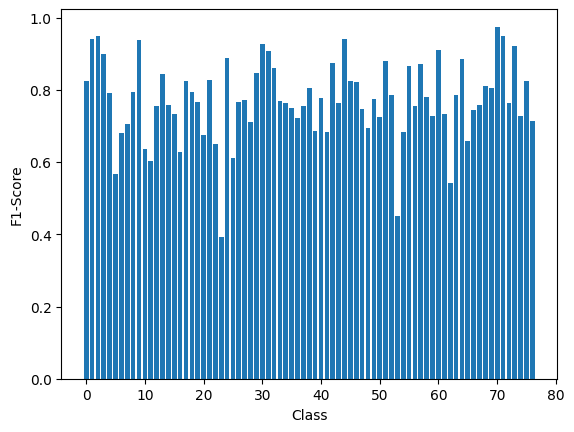

In [22]:
import matplotlib.pyplot as plt

f1_per_class = f1_score(y_test, y_pred, average=None)

plt.bar(range(len(f1_per_class)), f1_per_class)
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.show()

My parameters didn't allow to reach the score achieved in paper (77% vs 92%). However, the F1-score seemed still to increase at the end of the traninig, so probably more epochs with my hiperparameters could lead to a better result. The key factor of this average result can be inbalanced dataset with very few samples per class - augmentations could possibly be a wise choice while trying to increase the score in the future.

F1 scores per classes are very inbalanced - some classes were able to achieve very high scores, close to 1.0, on the other hand class `23`, that also had least samples, got the worst f1-score (around 0.39).

5. Use Giskard for behavioral testing:
   - modify `prediction_function()` appropriately
   - HuggingFace pipeline has `top_k=None` option to get scores for all labels, not just the label
     with the highest probability
   - analyze the results, are there any additional problems with the resulting classifier?

In [23]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan
from transformers.pipelines import pipeline

trained_model = trainer.model
trained_model.eval()
model_pipeline = pipeline(
    "text-classification",
    model=trained_model, 
    tokenizer=tokenizer,
    device="mps",
    top_k=None,
)

@torch.no_grad()
def prediction_function(df: pd.DataFrame):
    pred_output = model_pipeline(df["text"].tolist())
    y_pred_proba = [[pred_class["score"] for pred_class in preds] for preds in pred_output]
    return np.array(y_pred_proba)

df_test = load_dataset("PolyAI/banking77", split="test").to_pandas() 
giskard_dataset = GiskardDataset(df_test, target="label")

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=range(77),
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

Device set to use mps


2025-11-25 18:33:30,423 pid:8777 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2025-11-25 18:33:30,424 pid:8777 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
2025-11-25 18:33:30,431 pid:8777 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-25 18:33:30,723 pid:8777 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (10, 2) executed in 0:00:00.296040
2025-11-25 18:33:30,726 pid:8777 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-11-25 18:33:30,735 pid:8777 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.010767
2025-11-25 18:33:30,737 pid:8777 MainThread giskard.datasets.base INFO   

<iframe id="scan-16853154000" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collapse:co

6. Use Captum for local explainability:
   - modify the `explain_text` function from the lab to accommodate multiclass classification
   - explain predictions for a few samples from a test set
   - comment, is the model focusing on the right parts of texts?

In [28]:
from copy import deepcopy

from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis


class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]


def explain_text(model, text: str, y_true: int) -> None:
    # make sure we compute gradients as necessary
    for param in model.distilbert.parameters():
        param.requires_grad = True
    
    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    
    device = torch.device("mps")
    tokenizer_output = tokenizer_output.to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, "distilbert.embeddings"
    )
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=1,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    # mean normalization
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])
    
    with torch.no_grad():
        logits = model(**tokenizer_output).logits
        y_pred_proba = softmax(logits, dim=1)[0, 1].item()
        y_pred = int(y_pred_proba >= 0.5)

    # remove [CLS] and [SEP] tokens
    attributions = attributions[1:-1]
    tokens = tokens[1:-1]
    
    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=y_pred_proba,
        pred_class=y_pred,
        true_class=y_true,
        attr_class=y_true,
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )
    vis.visualize_text([vis_record])


In [30]:
for idx in random.sample(range(len(datasets_tokenized["test"])), 5):
    explain_text(model, datasets_tokenized["test"]["text"][idx], datasets_tokenized["test"]["label"][idx])

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
71,0 (0.00),71,-0.24,help me find the top - up card ' s verification code ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
54,0 (0.00),54,0.42,i would like to add money to my account through my american express .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
67,0 (0.00),67,0.07,"i initiated a bank transfer form europe , how long will this take ?"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
23,0 (0.00),23,0.04,for some reason my contact ##less has stopped working . i don ' t know what the problem is . what can i do ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
30,0 (0.00),30,-0.27,i want to change my name .


In general some words seem to make sense, such as `stopped` as negative word or `working` as positive, but on the other hand, setniment of the rest looks quite random.